## Mask Detection

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image
import numpy as np
import os

### Set Konstanta

In [2]:
LEARNINGRATE = 1e-4
EPOCHS = 20
BATCHSIZE = 32

dir = r"datasets"
categories = ["mask", "noMask"]

### Preproses Image

In [3]:
print("[Loading images...]")
data = []
labels = []
for category in categories:
	path = os.path.join(dir, category)
	for img in os.listdir(path):
		img_path = os.path.join(path, img)
		image = load_img(img_path, target_size=(224, 224))
		image = img_to_array(image)
		image = preprocess_input(image)

		data.append(image)
		labels.append(category)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

[Loading images...]


C:\Users\Ahmad Aziz\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


### Split Data for Train and Test

In [4]:
trainX, testX, trainY, testY = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=40)


### Augmentation

In [5]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	height_shift_range=0.2,
	width_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

### Construct the Head Model

In [6]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

### Model to Train

In [7]:
model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
	layer.trainable = False

### Compile Model

In [8]:
print("[Compiling model...]")
opt = Adam(learning_rate=LEARNINGRATE, decay=LEARNINGRATE / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

[Compiling model...]


### Train the Model

In [9]:
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BATCHSIZE),
	steps_per_epoch=len(trainX) // BATCHSIZE,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BATCHSIZE,
	epochs=EPOCHS)

Epoch 1/20
95/95 [==============================] - 83s 811ms/step - loss: 0.4188 - accuracy: 0.8388 - val_loss: 0.1681 - val_accuracy: 0.9778
Epoch 2/20
95/95 [==============================] - 82s 868ms/step - loss: 0.1607 - accuracy: 0.9598 - val_loss: 0.0837 - val_accuracy: 0.9844
Epoch 3/20
95/95 [==============================] - 87s 915ms/step - loss: 0.1028 - accuracy: 0.9763 - val_loss: 0.0625 - val_accuracy: 0.9844
Epoch 4/20
95/95 [==============================] - 86s 911ms/step - loss: 0.0780 - accuracy: 0.9789 - val_loss: 0.0522 - val_accuracy: 0.9844
Epoch 5/20
95/95 [==============================] - 92s 970ms/step - loss: 0.0640 - accuracy: 0.9802 - val_loss: 0.0474 - val_accuracy: 0.9857
Epoch 6/20
95/95 [==============================] - 101s 1s/step - loss: 0.0588 - accuracy: 0.9835 - val_loss: 0.0444 - val_accuracy: 0.9857
Epoch 7/20
95/95 [==============================] - 89s 942ms/step - loss: 0.0543 - accuracy: 0.9855 - val_loss: 0.0419 - val_accuracy: 0.9857
E

### Make Predictions on the Testing

In [10]:
print("[Predicting...")
predIdx = model.predict(testX, batch_size=BATCHSIZE)
predIdx = np.argmax(predIdx, axis=1)

print(classification_report(testY.argmax(axis=1), predIdx, target_names=lb.classes_))

[Predicting...
              precision    recall  f1-score   support

        mask       0.99      0.98      0.99       383
      noMask       0.98      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



In [11]:
# save trained model
print("[Saving mask detector model...]")
model.save("maskModel/trainedDetection.model", save_format="h5")

[Saving mask detector model...]


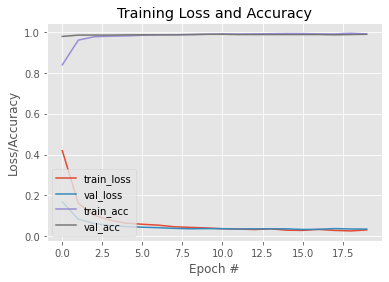

In [19]:
import matplotlib
matplotlib.use
import matplotlib.pyplot as plt
plt.style.use('ggplot')
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")